In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn import utils
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#Text Analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from textblob import TextBlob as tb
from IPython.display import Image as im
style.use('fivethirtyeight')

In [2]:
df = pd.read_pickle("./00_Dataset_Related/STARTER_DATASET.pkl")

In [3]:
df.head()

narrative   label
5   \nI (20 F) have been abused by different peopl...  unwell
6   I grew up with my dad laying on top of me when...  unwell
7   He would call me mommy and ask me to come wipe...  unwell
9   I never did anything when he said those things...  unwell
10  \n\nWhen I was in seventh grade I became depre...  unwell

In [4]:
df.label.value_counts()

well      2376
unwell    2376
Name: label, dtype: int64

# Text Cleaning

In [5]:
def clean_text(df, column_name):
    df['cleaned_text'] = df[column_name].fillna('')
    df['cleaned_text'] = df['cleaned_text'].str.lower()
    df['cleaned_text'] = df['cleaned_text'].str.replace(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|rt|\d+', '')
    df['cleaned_text'] = df['cleaned_text'].str.replace(r'^\s+|\s+$', '') 
    df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in (stopwords)]))
    return df

In [6]:
df = clean_text(df, "narrative")

# Dataset Analysis

In [7]:
# TFIDF
sentences = df["cleaned_text"]
tf_idf_vectorizer = TfidfVectorizer(max_features=4000)
tfidf = tf_idf_vectorizer.fit_transform(sentences)

print('TFIDF matrix shape:', tfidf.toarray().shape)
print('List: ', list(tf_idf_vectorizer.vocabulary_.items())[0:5])

total = tfidf.sum(axis=0)
frequency = [(w, total[0, i]) for w, i in tf_idf_vectorizer.vocabulary_.items()]
frequency = pd.DataFrame(frequency, columns=['term', 'frequency'])
frequency = frequency.sort_values(by='frequency', ascending=False).reset_index(drop=True)

frequency.head()

TFIDF matrix shape: (4752, 4000)
List:  [('abused', 11), ('different', 900), ('people', 2212), ('young', 3991), ('age', 68)]


term  frequency
0  happy  83.482553
1   time  78.934703
2     im  75.840005
3    got  75.351040
4   dont  67.438063

Text(0.5, 1.0, 'Top 20 Frequent terms with TF-IDF')

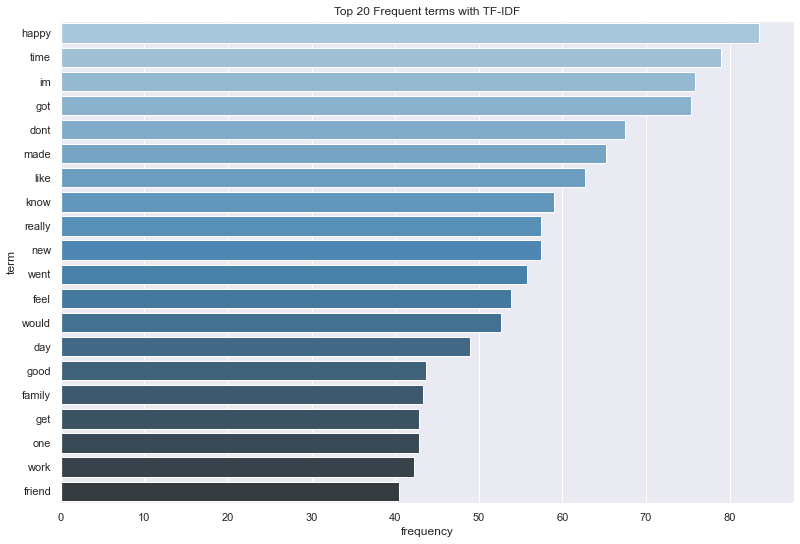

In [8]:
#Plot size
sns.set(rc={'figure.figsize':(11.7,8.27)})
# Plot
sns.barplot(data=frequency.head(20), x='frequency', y='term', palette="Blues_d").set_title('Top 20 Frequent terms with TF-IDF')

# Training

In [7]:
# Train/Test Split
train, test = model_selection.train_test_split(df, test_size=0.3, random_state=42)

### Sub-model 1 (Doc2vec)

In [10]:
#Word Tokenization
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r.cleaned_text), tags=[r.label]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r.cleaned_text), tags=[r.label]), axis=1)

print("Sample: ", train_tagged[0])

Sample:  TaggedDocument(['months', 'since', 'expired'], ['well'])


In [11]:
# Doc2Vec Modeling
import multiprocessing
cores = multiprocessing.cpu_count()

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=400)
model_dbow.alpha -= 0.002
model_dbow.min_alpha = model_dbow.alpha
model_dbow.save("../Current/SECOND_TRIAL/Exported_Models/doc2vec.model")
print("Model saved")

100%|██████████| 3326/3326 [00:00<00:00, 2646103.02it/s]


Model saved


In [12]:
#Converting word tokens int vectors
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [13]:
# Use for all sub-models
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [14]:
# SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train,y_train)

y_pred = SVM.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      unwell       0.92      0.93      0.92       718
        well       0.93      0.92      0.92       708

    accuracy                           0.92      1426
   macro avg       0.92      0.92      0.92      1426
weighted avg       0.92      0.92      0.92      1426



In [15]:
joblib.dump(SVM, '../Current/SECOND_TRIAL/Exported_Models/01_svm_model.pkl', compress=9)

['../Current/SECOND_TRIAL/Exported_Models/01_svm_model.pkl']

### Sub-model 2 (Behavioral)

In [8]:
%run './Utils/COMBINED.ipynb'

/usr/local/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/usr/local/lib/python3.8/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [15]:
# java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000
def get_behaviors_string(string):
    if not string: return ""
    
    string = re.sub(r'[^\w]', ' ', string)
    
    res = ""
    
    dic = get_behavior_breakdown(string)

    
    for key in dic:
        arr = dic[key]
        for i in arr:
            res += i + " "
        res += key + " "
        
        
    return res

In [ ]:
train["behavior"] = train.apply(lambda x: get_behaviors_string(x.cleaned_text), axis=1)

In [ ]:
test["behavior"] = test.apply(lambda x: get_behaviors_string(x.cleaned_text), axis=1)

In [20]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r.behavior), tags=[r.label]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r.behavior), tags=[r.label]), axis=1)

print("Sample: ", train_tagged[0])

Sample:  TaggedDocument(['expired'], ['well'])


In [21]:
# Doc2Vec Modeling for Behavioral
import multiprocessing
cores = multiprocessing.cpu_count()

model_dbow_beh = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow_beh.build_vocab([x for x in tqdm(train_tagged.values)])

model_dbow_beh.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1000)
model_dbow_beh.alpha -= 0.002
model_dbow_beh.min_alpha = model_dbow.alpha
model_dbow_beh.save("../Current/SECOND_TRIAL/Exported_Models/behavioral.model")
print("Model saved")

100%|██████████| 3326/3326 [00:00<00:00, 2695180.66it/s]


Model saved


In [ ]:
y_train, X_train = vec_for_learning(model_dbow_beh, train_tagged)
y_test, X_test = vec_for_learning(model_dbow_beh, test_tagged)

In [ ]:
# SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train,y_train)

y_pred = SVM.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
joblib.dump(SVM, '../Current/SECOND_TRIAL/Exported_Models/02_svm_model.pkl', compress=9)

### Sub Model 3 (Emotional)

In [ ]:
train["emotion"] = train["cleaned_text"].apply(lambda x: get_sentiment_breakdown(x))

In [ ]:
test["emotion"] = test["cleaned_text"].apply(lambda x: get_sentiment_breakdown(x))

In [ ]:
sentiments_train = pd.DataFrame(columns=["negative", "positive", "fear", "anger", "trust", "sadness", "disgust", "anticip", "surprise", "joy"])
sentiments_test = pd.DataFrame(columns=["negative", "positive", "fear", "anger", "trust", "sadness", "disgust", "anticip", "surprise", "joy"])

In [ ]:
for key, value in train.emotion.iteritems():
    sentiments_train = sentiments_train.append(value, ignore_index=True)
    
for key, value in test.emotion.iteritems():
    sentiments_test = sentiments_test.append(value, ignore_index=True)

In [ ]:
sentiments_train = sentiments_train.fillna(0)
sentiments_test = sentiments_test.fillna(0)

sentiments_train["emotion_array"] = sentiments_train.values.tolist()
sentiments_test["emotion_array"] = sentiments_test.values.tolist()

In [ ]:
train = pd.concat([train, sentiments_train.set_index(train.index)["emotion_array"]], axis=1)
test = pd.concat([test, sentiments_test.set_index(test.index)["emotion_array"]], axis=1)

In [ ]:
X_train = train.emotion_array.to_list()
X_test = test.emotion_array.to_list()
y_train = train.label.to_list()
y_test = test.label.to_list()

In [ ]:
# SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train,y_train)

y_pred = SVM.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
joblib.dump(SVM, '../Current/SECOND_TRIAL/Exported_Models/03_svm_model.pkl', compress=9)

In [ ]:
joblib.dump(X_test, '../Current/SECOND_TRIAL/Exported_Models/X_test.pkl', compress=9)
joblib.dump(y_test, '../Current/SECOND_TRIAL/Exported_Models/y_test.pkl', compress=9)